# Generate Genetic Distance Error vs JSD Plots
### Setup

In [1]:
import os
from json import dumps

from pymongo import MongoClient
from pandas import DataFrame
from IPython.display import Markdown, display, Image

import lib
from outliers import qcrop
from rpy2.robjects import StrVector, FactorVector

In [2]:
%load_ext rpy2.ipython
%R library(ggplot2)

array(['ggplot2', 'quantreg', 'SparseM', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [3]:
try:
    os.mkdir('genetic_distance')
except OSError:
    pass

### Utility

In [4]:
def get_max_pairwise_jsds(col):
    result = {}
    for doc in col.find({},{'_id' : True, 'lf' : True}):
        jsds = [(j, eval(p)) for p, j in doc['lf']['js'].items()]
        result[doc['_id']] = max([(j, p) for j, p in jsds if len(p) == 2])
    return result

def get_points(jsds, col1, col2):
    x = []
    y = []
    col1 = {d['_id']:d['lf']['EN'] for d in col1.find() 
            if max(d['lf']['params']['length'].values()) < 10.-1e-4}
    col2 = {d['_id']:d['lf']['EN'] for d in col2.find()
            if max(d['lf']['params']['length'].values()) < 10.-1e-4}
    for _id, (jsd, pair) in jsds.items():
        if not _id in col1 or not _id in col2:
            continue
        x.append(jsd)
        ens1 = sum(col1[_id][taxon] for taxon in pair)
        ens2 = sum(col2[_id][taxon] for taxon in pair)
        y.append(ens2 - ens1)
    return x, y

def get_distance_error_dataframe(database):
    mpj = get_max_pairwise_jsds(database.GNC)
    xes, yes = [], []
    x, y = get_points(mpj, database.GNC, database.Y98)
    print 'Y98 points', len(x)
    xes.append(x)
    yes.append(y)
    x, y = get_points(mpj, database.GNC, database.CNFGTR)
    xes.append(x)
    yes.append(y)
    print 'CNFGTR points', len(x)

    return qcrop(xes, yes, ['Y98', 'CNFGTR'])

def print_logs(log,  level='INFO'):
    printmd('##### ' + log.name)
    for d in log.find({'level':level}):
        printmd(dumps(d['message']))
        
def printmd(string):
    ''' thanks http://stackoverflow.com/questions/32026727/format-output-of-code-cell-with-markdown '''
    display(Markdown(string))

In [5]:
%%R
get_ggplot <- function(df)
{
    ggplot(df, aes(x,y)) +
        geom_point(aes(xcrop, ycrop), alpha=0.5, size=0.5) +
        xlab('Max Pairwise JSD Over Triad') +
        ylab('Corresponding Genetic Distance Error') +
        stat_quantile(aes(x, y), colour="white", size=1.5, alpha=0.5) +
        stat_quantile(aes(x, y), colour="black") +
        facet_grid(facet ~ ., space="free", scale="free", labeller=label_parsed)
}

### Load the Data

In [6]:
client = MongoClient()

In [7]:
cols = ['GNC', 'Y98', 'CNFGTR']
datasets = ['mammals', 'ants', 'hum_xen_fug']
ds_names = {'mammals' : 'Mammals',
            'ants' : 'Ants',
            'hum_xen_fug' : 'Human/Xenopus/Fugu',
            'introns' : 'Primate Introns'}
for dataset in datasets:
    printmd('#### ' + ds_names[dataset])
    for col in ['data'] + cols:
        print_logs(getattr(getattr(client, dataset), col + '.log'))

#### Mammals

##### data.log

{"input_directory": "/short/xe9/bdk248/data/mammals", "log_level": "DEBUG", "output_collection": "mammals.data", "tree_file": "../config/mammals.nwk", "db_host": "r2081", "aln_length": 1500, "log_name": "log", "codon_position": -1}

{"mong": "0.0.10-dev", "cogent": "1.5.3-dev", "masterslave": "0.0.10-dev", "consume": "0.0.5-dev", "monglog": "0.0.1-dev"}

##### GNC.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/GNC.json", "input_collection": "mammals.data", "output_collection": "mammals.GNC", "output_collections_file": null, "output_collections": ["mammals.GNC"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "GNC"}, "log_name": "log", "input_collections": ["mammals.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### Y98.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/Y98.json", "input_collection": "mammals.data", "output_collection": "mammals.Y98", "output_collections_file": null, "output_collections": ["mammals.Y98"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "Y98"}, "log_name": "log", "input_collections": ["mammals.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### CNFGTR.log

{"function": "ml.ml", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/CNFGTR.json", "input_collection": "mammals.data", "output_collection": "mammals.CNFGTR", "output_collections_file": null, "output_collections": ["mammals.CNFGTR"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "CNFGTR"}, "log_name": "log", "input_collections": ["mammals.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

#### Ants

##### data.log

{"input_directory": "/short/xe9/bdk248/../data/ants", "log_level": "DEBUG", "output_collection": "ants.data", "tree_file": "../config/ants.nwk", "db_host": "r2081", "aln_length": 1500, "log_name": "log", "codon_position": -1}

{"mong": "0.0.10-dev", "cogent": "1.5.3-dev", "masterslave": "0.0.10-dev", "consume": "0.0.5-dev", "monglog": "0.0.1-dev"}

##### GNC.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/GNC.json", "input_collection": "ants.data", "output_collection": "ants.GNC", "output_collections_file": null, "output_collections": ["ants.GNC"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "GNC"}, "log_name": "log", "input_collections": ["ants.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### Y98.log

{"function": "ml.ml", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/Y98.json", "input_collection": "ants.data", "output_collection": "ants.Y98", "output_collections_file": null, "output_collections": ["ants.Y98"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "Y98"}, "log_name": "log", "input_collections": ["ants.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### CNFGTR.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/CNFGTR.json", "input_collection": "ants.data", "output_collection": "ants.CNFGTR", "output_collections_file": null, "output_collections": ["ants.CNFGTR"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "CNFGTR"}, "log_name": "log", "input_collections": ["ants.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

#### Human/Xenopus/Fugu

##### data.log

{"input_directory": "/short/xe9/bdk248/../data/hum_xen_fug", "log_level": "DEBUG", "output_collection": "hum_xen_fug.data", "tree_file": "../config/hum_xen_fug.nwk", "db_host": "r2081", "aln_length": 1500, "log_name": "log", "codon_position": -1}

{"mong": "0.0.10-dev", "cogent": "1.5.3-dev", "masterslave": "0.0.10-dev", "consume": "0.0.5-dev", "monglog": "0.0.1-dev"}

##### GNC.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/GNC.json", "input_collection": "hum_xen_fug.data", "output_collection": "hum_xen_fug.GNC", "output_collections_file": null, "output_collections": ["hum_xen_fug.GNC"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "GNC"}, "log_name": "log", "input_collections": ["hum_xen_fug.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### Y98.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/Y98.json", "input_collection": "hum_xen_fug.data", "output_collection": "hum_xen_fug.Y98", "output_collections_file": null, "output_collections": ["hum_xen_fug.Y98"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "Y98"}, "log_name": "log", "input_collections": ["hum_xen_fug.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### CNFGTR.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/CNFGTR.json", "input_collection": "hum_xen_fug.data", "output_collection": "hum_xen_fug.CNFGTR", "output_collections_file": null, "output_collections": ["hum_xen_fug.CNFGTR"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "CNFGTR"}, "log_name": "log", "input_collections": ["hum_xen_fug.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

In [8]:
dfs = {}
for dataset in datasets:
    printmd('#### ' + ds_names[dataset])
    df = get_distance_error_dataframe(getattr(client, dataset))
    dfs[dataset] = df

#### Mammals

Y98 points 4140
CNFGTR points 4149
              tau= 0.25   tau= 0.50    tau= 0.75
(Intercept) -0.02866292 -0.01310558 -0.002022891
x            5.70224604  7.51443606 11.086093852

              tau= 0.25   tau= 0.50  tau= 0.75
(Intercept) -0.01607574 0.005158551 0.02819891
x            4.50082083 5.555209807 7.40949922



#### Ants

Y98 points 2019
CNFGTR points 2019
              tau= 0.25   tau= 0.50  tau= 0.75
(Intercept) -0.01974957 0.003169953 0.05867508
x            4.65221493 6.055820724 7.51124650

              tau= 0.25   tau= 0.50   tau= 0.75
(Intercept) -0.02601999 -0.01223048 0.008642086
x            3.57217675  4.54447689 5.601729138



#### Human/Xenopus/Fugu

Y98 points 1074
CNFGTR points 1622
            tau= 0.25 tau= 0.50 tau= 0.75
(Intercept)   1.16515  3.619566  6.388209
x            19.64215 12.115354  3.587815

             tau= 0.25 tau= 0.50 tau= 0.75
(Intercept)  0.5237923  1.012235  1.916416
x           12.2848936 16.847454 21.486945



### Generate the Plots

#### Mammals

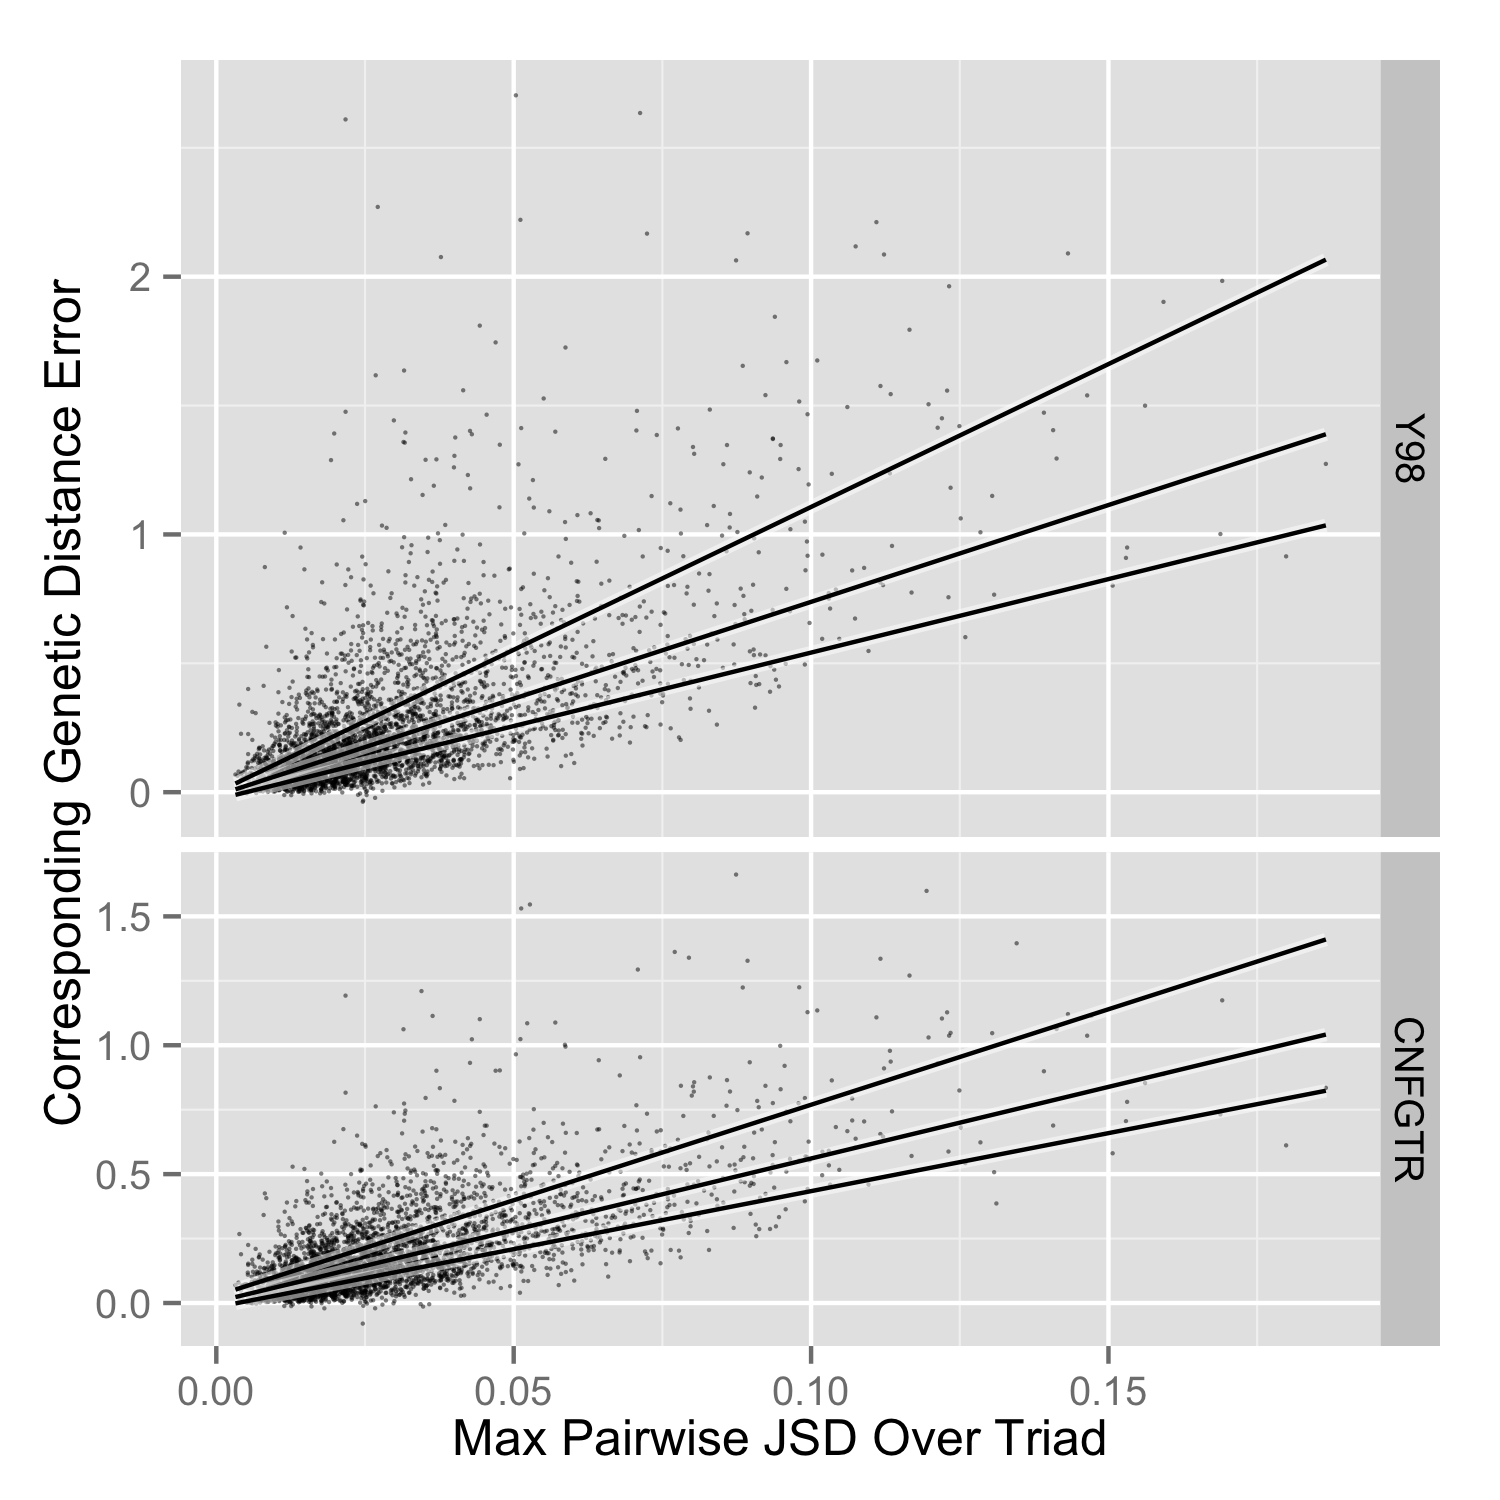

#### Human/Xenopus/Fugu

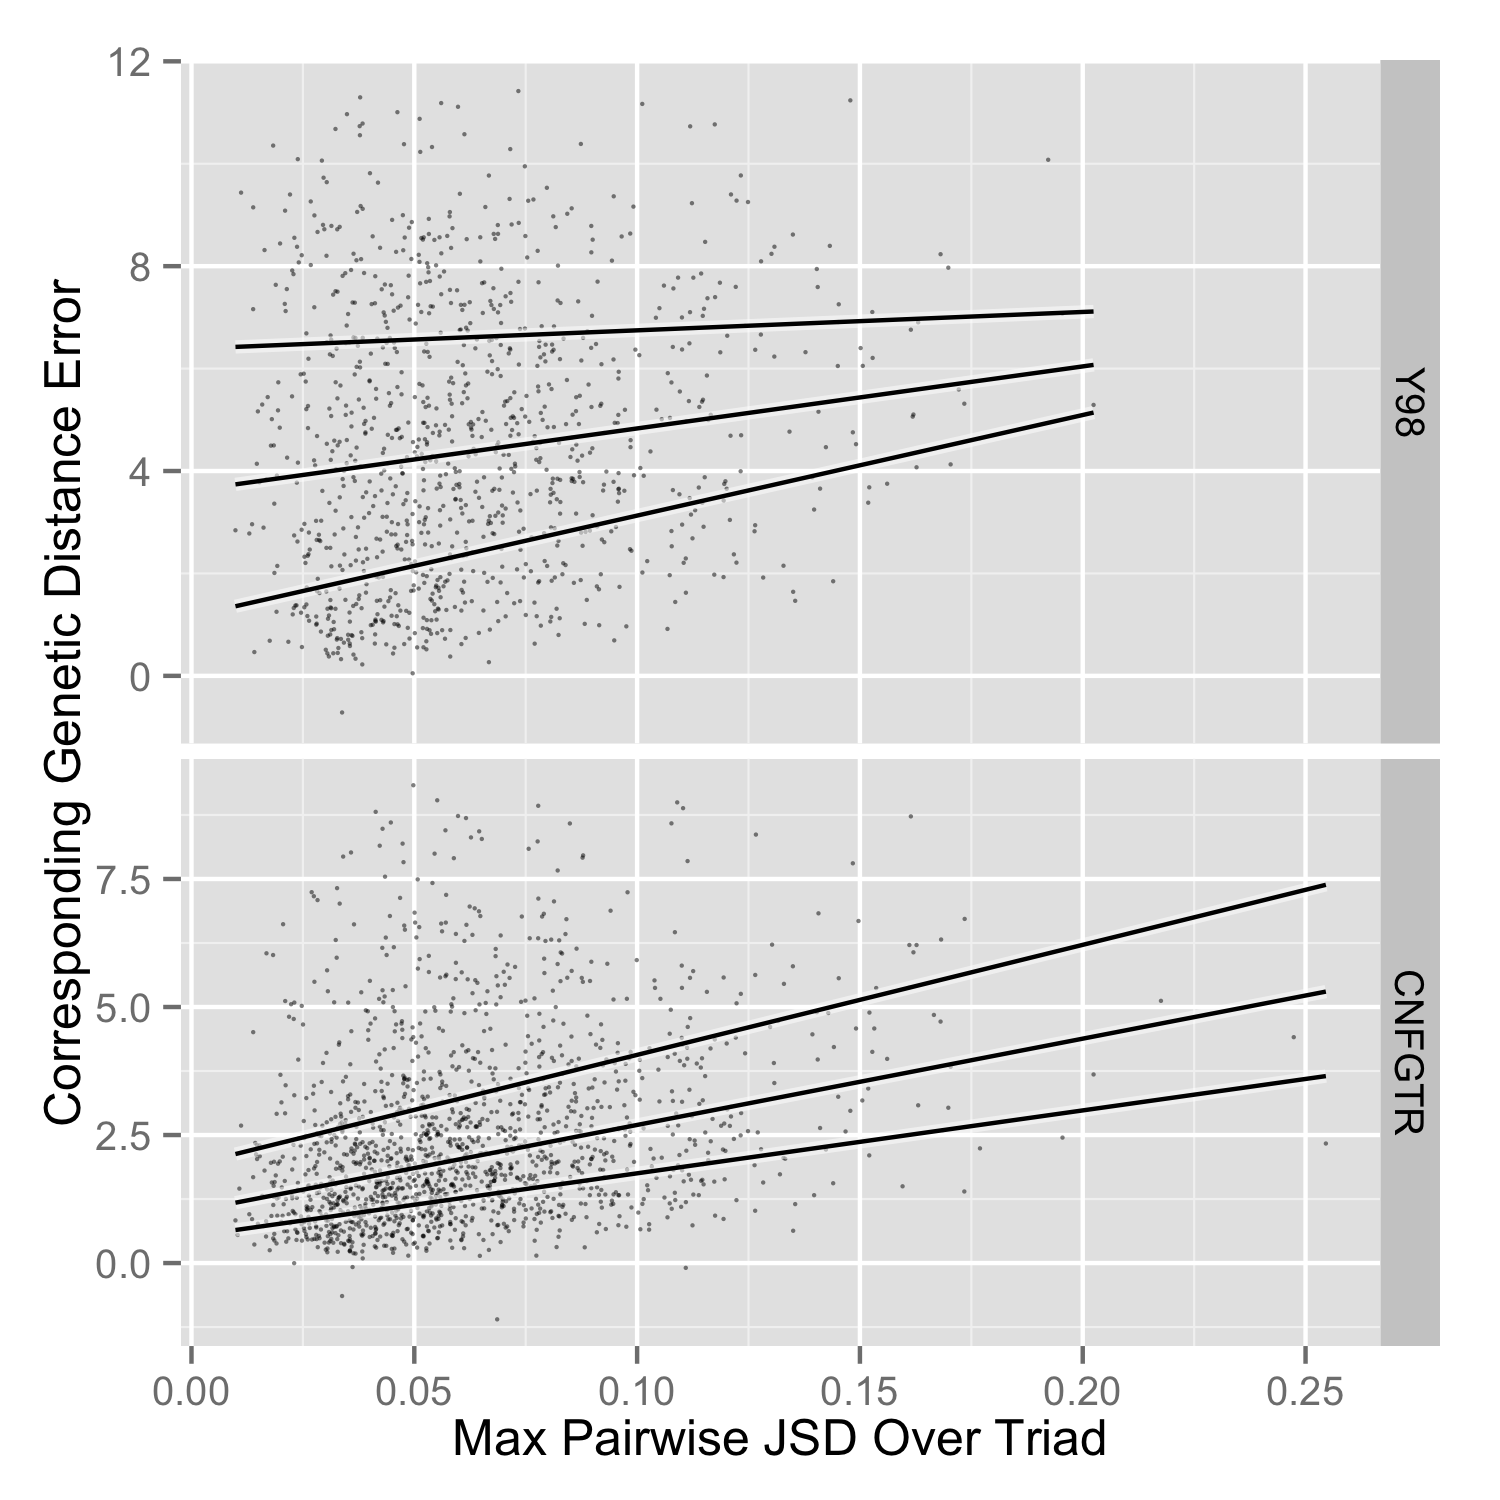

#### Ants

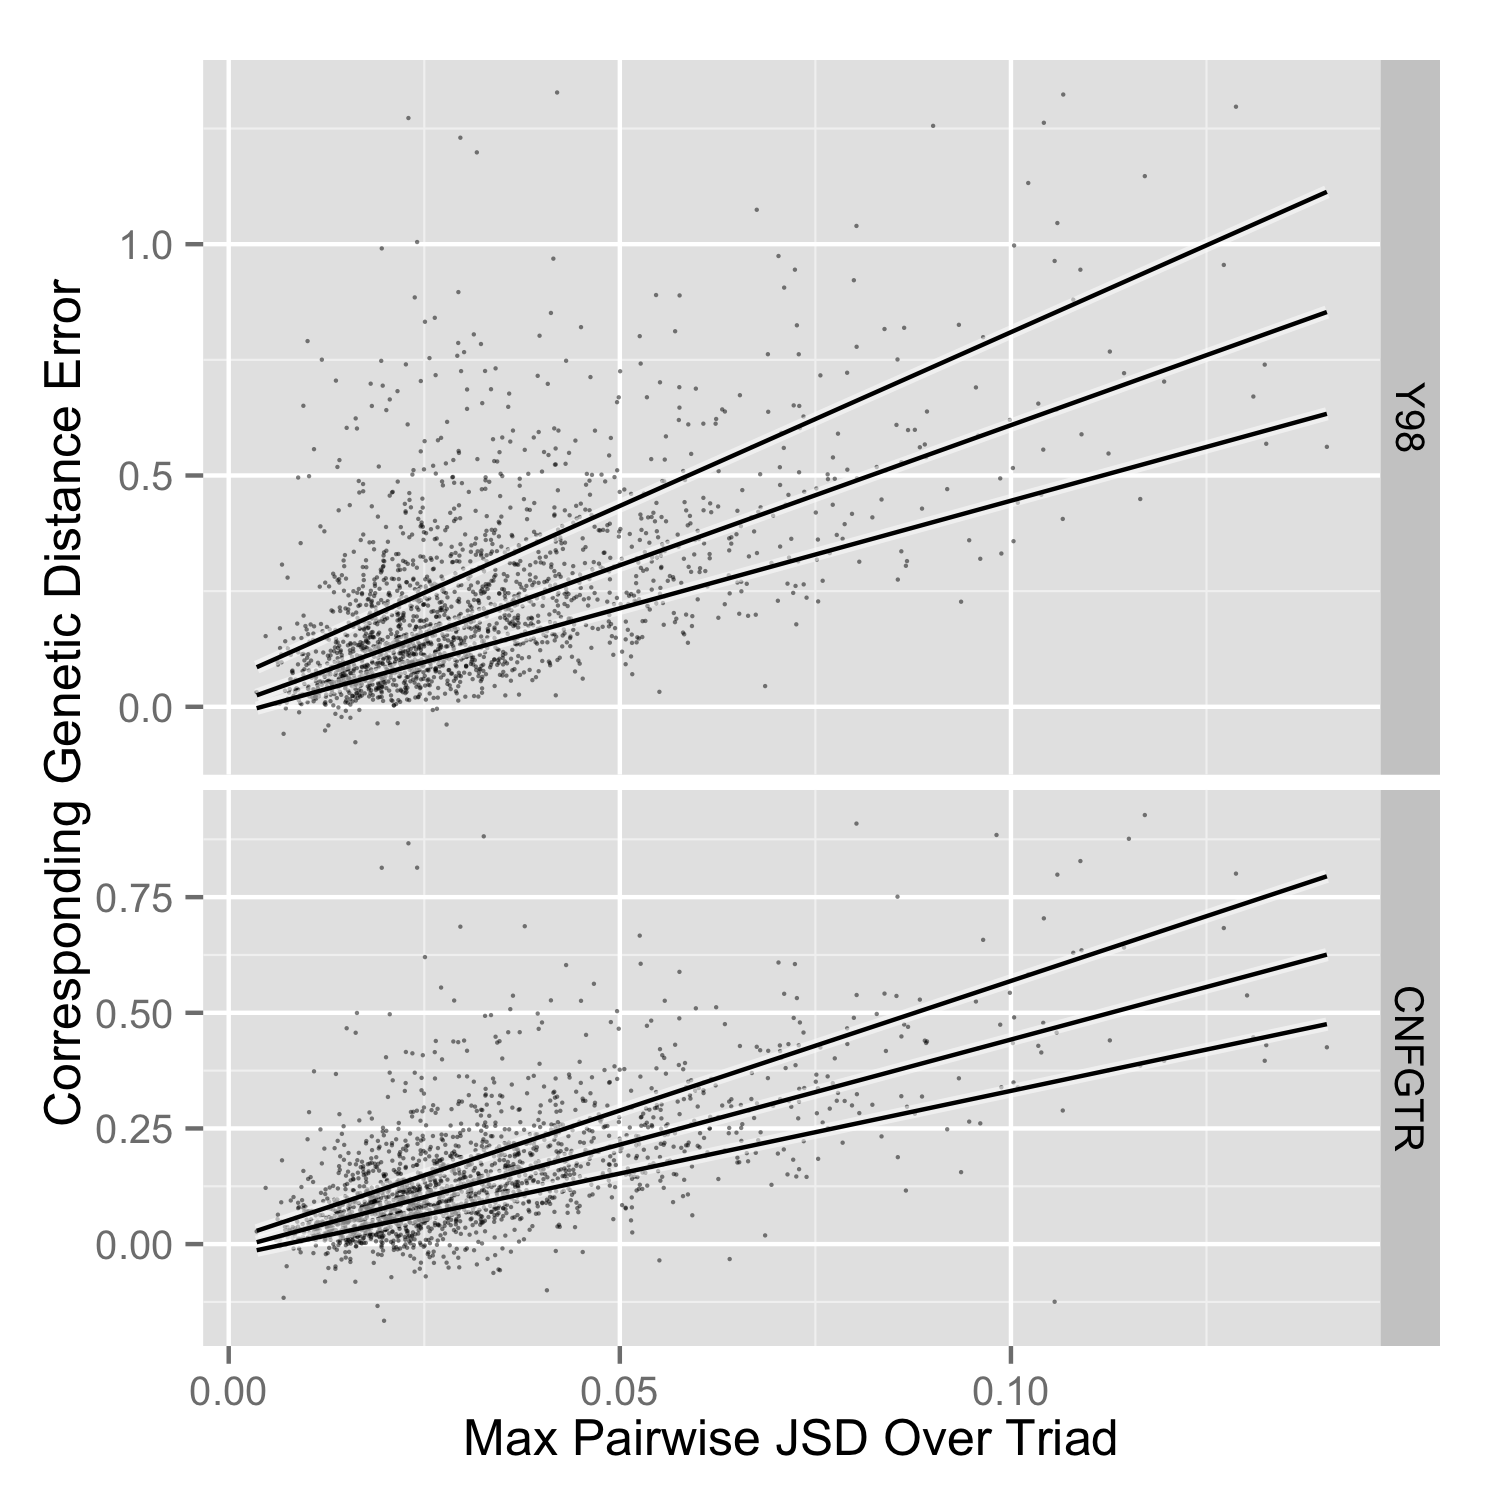

In [12]:
for name, df in dfs.items():
    printmd('#### ' + ds_names[name])
    name = os.path.join('genetic_distance', name + '.png')
    %R -i df gg <- get_ggplot(df)
    %R -i name ggsave(name, gg, width=5, height=5)
    display(Image(name))